In [1]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
# Connecting to the Database
print("Trying to connect to db")
conn = psycopg2.connect(
    database="piscineds",
    user="ggobert",
    password="mysecretpassword",
    host=0
)
print("Connection success!")

cur = conn.cursor()

cur.execute("""
    WITH user_data AS (
        SELECT 
            user_id,
            SUM(CAST(REPLACE(REPLACE(price::text, '$', ''), ',', '') AS FLOAT)) AS price,
            COUNT(*) AS event_count,
            COUNT(DISTINCT product_id) AS unique_products,
            COUNT(DISTINCT user_session) AS unique_sessions
        FROM customers
        GROUP BY user_id
    ),
    stats AS (
        SELECT
            AVG(price) AS avg_price,
            STDDEV_POP(price) AS std_price,
            AVG(event_count) AS avg_event,
            STDDEV_POP(event_count) AS std_event,
            AVG(unique_products) AS avg_product,
            STDDEV_POP(unique_products) AS std_product,
            AVG(unique_sessions) AS avg_session,
            STDDEV_POP(unique_sessions) AS std_session
        FROM user_data
    )
    SELECT
        (price - stats.avg_price) / NULLIF(stats.std_price, 0) AS price_scaled,
        (event_count - stats.avg_event) / NULLIF(stats.std_event, 0) AS event_scaled,
        (unique_products - stats.avg_product) / NULLIF(stats.std_product, 0) AS product_scaled,
        (unique_sessions - stats.avg_session) / NULLIF(stats.std_session, 0) AS session_scaled
    FROM user_data, stats;
""")

results = cur.fetchall()

cur.close()
conn.close()

Trying to connect to db
Connection success!


In [10]:
std_data = np.array(results)
std_data = std_data.astype(float)
clean_data = std_data[~np.isnan(std_data).any(axis=1)]

In [12]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clean_data)
    inertia.append(kmeans.inertia_)

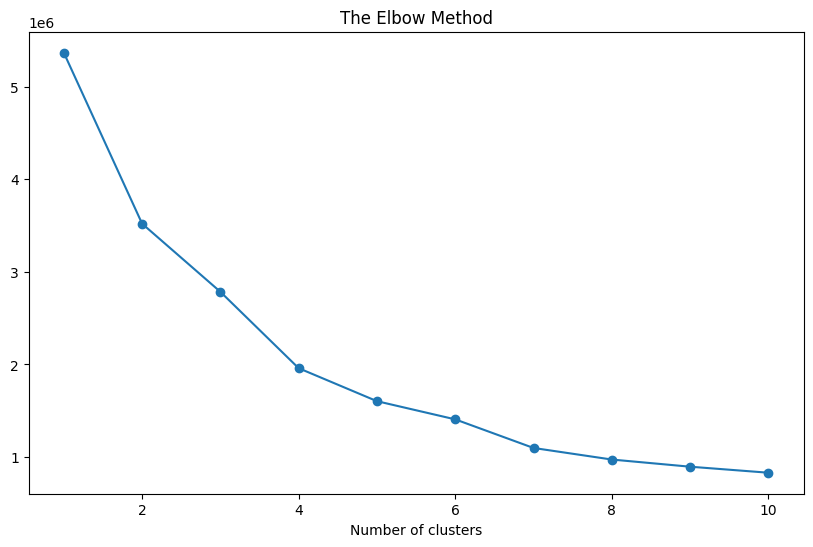

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.show()